# Library

In [ ]:
import os
import cv2 as cv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report,f1_score, make_scorer
from skimage.feature import hog
from skimage import exposure
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from six import StringIO
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from joblib import dump, load
from sklearn.metrics import confusion_matrix
from google.colab import drive
drive.mount('/gdrive')


Mounted at /gdrive


#Load Data

In [ ]:
data_path = '/gdrive/MyDrive/CS231_MODEL/Data'
os.listdir(data_path)

# Khởi tạo danh sách hình ảnh và nhãn
data = []
labels = []

# Lặp lại các đường dẫn đầu vào để đọc dữ liệu
for class_name in os.listdir(data_path):
  class_path = os.path.join(data_path, class_name)
  #Load ảnh
  for image in os.listdir(class_path):
    image_path = os.path.join(class_path, image)
    image = cv.imread(image_path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image = cv.resize(image, (224, 224))
      # Nạp ảnh
    data.append(image)
      # Nạp nhãn
    labels.append(class_name)

In [ ]:
len(data)

830

In [ ]:
(X_train, X_test, y_train, y_test) = train_test_split(data, labels, test_size=0.3, random_state=7) # Chia data thành tập train và test: 70-30

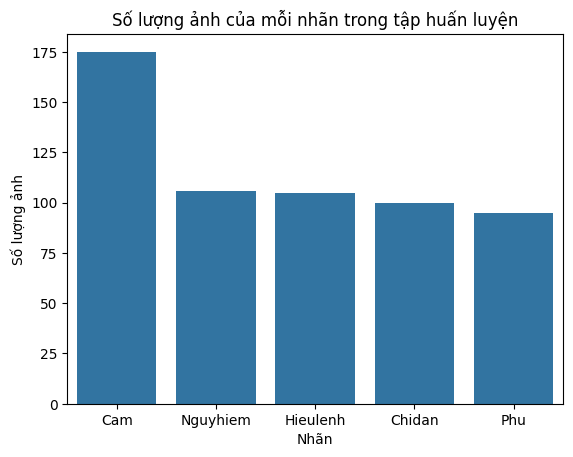

In [ ]:
# Số lượng Image mỗi class trong tập train
label_counts_train = pd.Series(y_train).value_counts()
sns.barplot(x=label_counts_train.index, y=label_counts_train.values)
plt.title('Số lượng ảnh của mỗi nhãn trong tập huấn luyện')
plt.xlabel('Nhãn')
plt.ylabel('Số lượng ảnh')
plt.show()

# Augementation

In [ ]:
type(X_train)

list

In [ ]:
# Làm mờ ảnh
def blur_image(img):
    return cv.GaussianBlur(img, (7, 7), 0)

# Hàm tăng cường dữ liệu
def custom_augmentation():
    datagen = ImageDataGenerator(
        rotation_range=10,          # Xoay ngẫu nhiên từ -10 đến 10 độ
        width_shift_range=0.1,      # Dịch chuyển ngang trong khoảng ±10%
        height_shift_range=0.1,     # Dịch chuyển dọc trong khoảng ±10%
        shear_range=0.1,            # Biến đổi shear trong khoảng ±10%
        zoom_range = 0.5,             # Phóng to hoặc thu nhỏ trong khoảng ±50%
        horizontal_flip=False,      # Không lật ngang (vì biển báo không bị lật)
        fill_mode='nearest',        # Điền các pixel trống bằng giá trị pixel gần nhất
        preprocessing_function=blur_image  # Hàm tùy chỉnh để làm mờ ảnh
    )
    return datagen

In [ ]:
datagen = custom_augmentation()

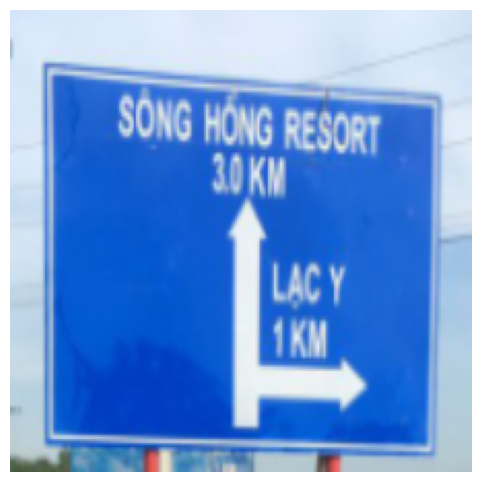

In [ ]:
# Example
img_exam = '/content/Screenshot 2024-05-09 181212.png'
plt.figure(figsize = (8, 6))
img_exam = cv.imread(img_exam)
img_exam = cv.cvtColor(img_exam, cv.COLOR_BGR2RGB)
img_exam = cv.resize(img_exam, (224, 224))
plt.imshow(img_exam)
plt.axis('off')
plt.show()

In [ ]:
new_image = []
img_exam_datagen = img_exam.reshape((1,) + img_exam.shape)
aug_iter = datagen.flow(img_exam_datagen, batch_size=1)
for j in range(10):
        aug_img = next(aug_iter)[0].astype('uint8')
        new_image.append(aug_img)


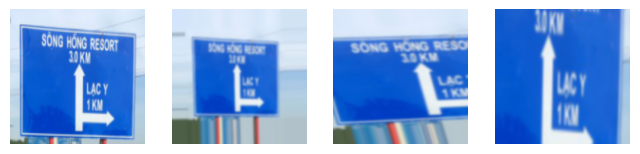

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(8, 6))
axes[0].imshow(img_exam)
axes[0].axis('off')
axes[1].imshow(new_image[0])
axes[1].axis('off')
axes[2].imshow(new_image[1])
axes[2].axis('off')
axes[3].imshow(new_image[2])
axes[3].axis('off')
plt.show()

In [ ]:
new_image[2].shape

(224, 224, 3)

In [ ]:
leng = len(X_train)
for i in range(leng):
    img = X_train[i]
    label = y_train[i]
    img = img.reshape((1,) + img.shape)
    aug_iter = datagen.flow(img, batch_size=1)
    for j in range(3):
        aug_img = next(aug_iter)[0].astype('uint8')
        X_train.append(aug_img)
        y_train.append(label)

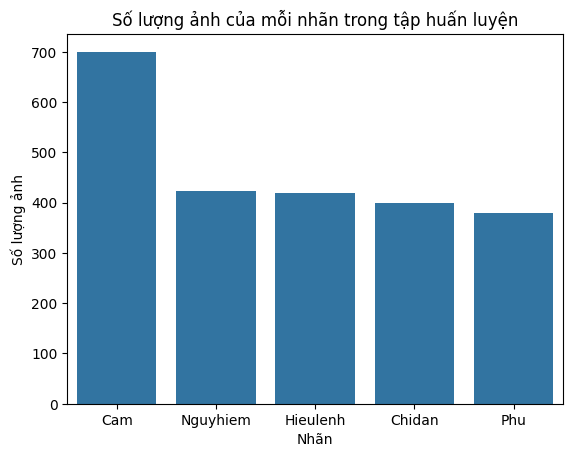

In [ ]:
# Số lượng Image mỗi class trong tập train
label_counts_train = pd.Series(y_train).value_counts()
sns.barplot(x=label_counts_train.index, y=label_counts_train.values)
plt.title('Số lượng ảnh của mỗi nhãn trong tập huấn luyện')
plt.xlabel('Nhãn')
plt.ylabel('Số lượng ảnh')
plt.show()

# Extract features

In [ ]:
# Histogram màu
def extract_color_histogram(image):
    hist = cv.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    hist = cv.normalize(hist, hist).flatten()  # Chuẩn hóa và làm phẳng
    return hist

In [ ]:
# HOG
def extract_hog_features(image):

    gray = cv.cvtColor(image, cv.COLOR_RGB2GRAY)

    hog_features, hog_image = hog(gray, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, block_norm='L2-Hys', transform_sqrt = True)

    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    return hog_features, hog_image_rescaled

In [ ]:
# Hàm kết hợp các features
def combined_features(image):
    # Tính toán gradient và HOG
    hog_features, hog_image_rescaled = extract_hog_features(image)

    # Tính toán histogram màu
    hist = extract_color_histogram(image)

    return np.hstack((hog_features, hist))

In [ ]:
X_train_features = np.array([combined_features(img) for img in X_train])
X_test_features = np.array([combined_features(img) for img in X_test])

In [ ]:
X_train_features.shape

(2324, 26756)

In [ ]:
len(y_train)

2324

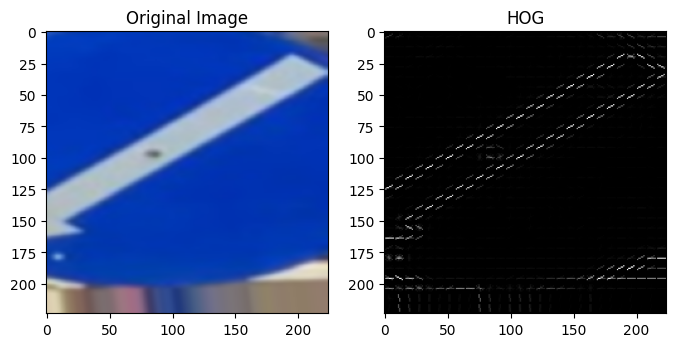

In [ ]:
plt.figure(figsize = (8, 6))
plt.subplot(1, 2, 1)
plt.imshow(X_train[1000])
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(extract_hog_features(X_train[1000])[1], cmap = 'gray')
plt.title('HOG')
plt.show()

In [ ]:
print(y_train[1000])

Hieulenh


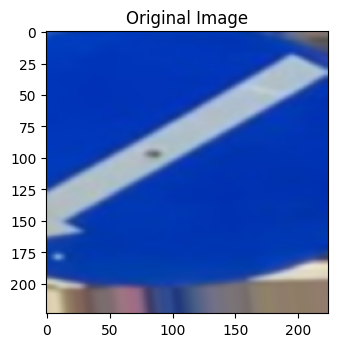

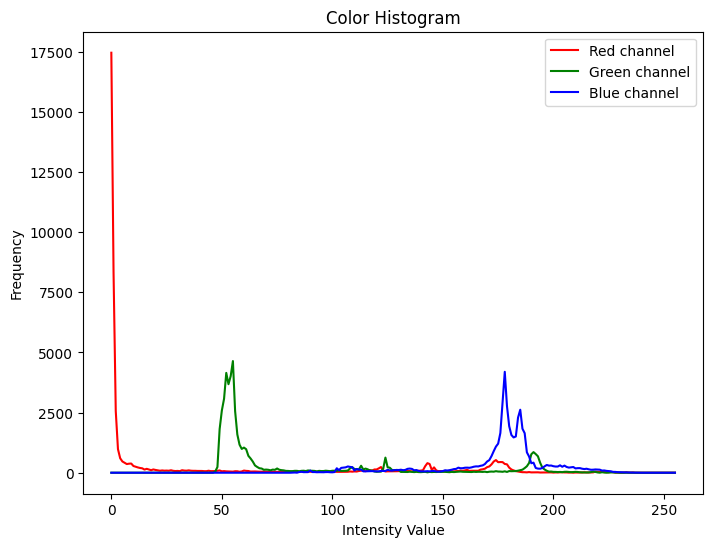

In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def extract_color_histogram_RGB(image):
    hist_red = cv.calcHist([image], [0], None, [256], [0, 256])
    hist_green = cv.calcHist([image], [1], None, [256], [0, 256])
    hist_blue = cv.calcHist([image], [2], None, [256], [0, 256])
    return hist_red, hist_green, hist_blue

def plot_color_histogram_2d(hist_red, hist_green, hist_blue):
    plt.figure(figsize=(8, 6))
    plt.plot(hist_red, color='r', label='Red channel')
    plt.plot(hist_green, color='g', label='Green channel')
    plt.plot(hist_blue, color='b', label='Blue channel')
    plt.title('Color Histogram')
    plt.xlabel('Intensity Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()


plt.figure(figsize=(8, 6))

temp = 1000

plt.subplot(1, 2, 1)
plt.imshow(X_train[temp])
plt.title('Original Image')

hist_red, hist_green, hist_blue = extract_color_histogram_RGB(X_train[temp])
plot_color_histogram_2d(hist_red, hist_green, hist_blue)

plt.show()


# Save and load feature

In [ ]:
path_features = '/gdrive/MyDrive/CS231_MODEL/Save_features/'
dump(X_train_features, path_features + 'X_train_features.joblib')
dump(y_train, path_features + 'y_train.joblib')
dump(X_test_features, path_features + 'X_test_features.joblib')
dump(y_test, path_features + 'y_test.joblib')

In [ ]:
# Chạy cái này nè :>
path_features = '/gdrive/MyDrive/CS231_MODEL/Save_features/'
X_train_features = load(path_features + 'X_train_features.joblib')
y_train = load(path_features + 'y_train.joblib')
X_test_features = load(path_features + 'X_test_features.joblib')
y_test = load(path_features + 'y_test.joblib')

In [ ]:
X_train_features.shape

(2324, 26756)

In [ ]:
len(y_train)

2324

# KNN

In [ ]:
#KNN
knn = KNeighborsClassifier()
knn.fit(X_train_features, y_train)

KNeighborsClassifier()

In [ ]:
test_prediction_knn = knn.predict((X_test_features))
test_accuracy_knn = accuracy_score(y_test, test_prediction_knn)
print("Test accuracy with knn:", test_accuracy_knn)

Test accuracy with knn: 0.6465863453815262


In [ ]:
print("Classification report:")
print(classification_report(y_test, test_prediction_knn))

Classification report:
              precision    recall  f1-score   support

         Cam       0.81      0.81      0.81        67
      Chidan       0.71      0.31      0.43        49
    Hieulenh       0.38      0.75      0.51        52
    Nguyhiem       1.00      0.80      0.89        51
         Phu       0.67      0.40      0.50        30

    accuracy                           0.65       249
   macro avg       0.71      0.61      0.63       249
weighted avg       0.72      0.65      0.65       249



# Tối ưu KNN

In [ ]:
knn = KNeighborsClassifier(metric = 'euclidean', n_neighbors = 3, weights = 'distance')
knn.fit(X_train_features, y_train)

test_prediction_knn = knn.predict((X_test_features))
test_accuracy_knn = accuracy_score(y_test, test_prediction_knn)
print("Test accuracy with knn:", test_accuracy_knn)

Test accuracy with knn: 0.7068273092369478


In [ ]:
print("KNN with optimal parameters Classification report:")
print(classification_report(y_test, test_prediction_knn))

KNN with optimal parameters Classification report:
              precision    recall  f1-score   support

         Cam       0.84      0.87      0.85        67
      Chidan       0.76      0.39      0.51        49
    Hieulenh       0.44      0.83      0.58        52
    Nguyhiem       1.00      0.82      0.90        51
         Phu       0.88      0.47      0.61        30

    accuracy                           0.71       249
   macro avg       0.78      0.67      0.69       249
weighted avg       0.78      0.71      0.71       249



# GridSearch KNN

In [ ]:

param_grid = {
    #'pca__n_components': [20, 30, 40],  # Số lượng thành phần chính cho PCA
    'n_neighbors': [3, 5, 7, 9, 11, 13],
    'metric': ['euclidean', 'manhattan'],
    'weights': ['uniform', 'distance']
}
model = KNeighborsClassifier()
grid_search_knn = GridSearchCV(estimator=model, param_grid = param_grid, cv=5, scoring='accuracy')

grid_search_knn.fit(X_train_features, y_train)

print("Best parameters:", grid_search_knn.best_params_)
print("Best model:", grid_search_knn.best_estimator_)

Best parameters: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
Best model: KNeighborsClassifier(metric='euclidean', n_neighbors=3, weights='distance')


In [ ]:
results = grid_search_knn.cv_results_
for mean_score, params in zip(results['mean_test_score'], results['params']):
    print(f"Mean accuracy: {mean_score:.4f}, Parameters: {params}")

Mean accuracy: 0.6179, Parameters: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
Mean accuracy: 0.6385, Parameters: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
Mean accuracy: 0.6119, Parameters: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}
Mean accuracy: 0.6308, Parameters: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}
Mean accuracy: 0.6140, Parameters: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'uniform'}
Mean accuracy: 0.6278, Parameters: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}
Mean accuracy: 0.6063, Parameters: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'uniform'}
Mean accuracy: 0.6209, Parameters: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}
Mean accuracy: 0.5972, Parameters: {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'uniform'}
Mean accuracy: 0.6157, Parameters: {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'distance'}
Mea

In [ ]:
test_prediction = grid_search_knn.predict(X_test_features)
test_accuracy = accuracy_score(y_test, test_prediction)
print("Test accuracy-score:", test_accuracy)

Test accuracy-score: 0.7068273092369478


In [ ]:
print("KNN with optimal parameters Classification report:")
print(classification_report(y_test, test_prediction))

KNN with optimal parameters Classification report:
              precision    recall  f1-score   support

         Cam       0.84      0.87      0.85        67
      Chidan       0.76      0.39      0.51        49
    Hieulenh       0.44      0.83      0.58        52
    Nguyhiem       1.00      0.82      0.90        51
         Phu       0.88      0.47      0.61        30

    accuracy                           0.71       249
   macro avg       0.78      0.67      0.69       249
weighted avg       0.78      0.71      0.71       249



# Conf_matrix

In [ ]:
label_encoding = {
    'Cam': 0,
    'Chidan': 1,
    'Hieulenh': 2,
    'Nguyhiem': 3,
    'Phu': 4
}

In [ ]:
y_test_encoded = [label_encoding[label] for label in y_test]
test_prediction_knn_encoded = [label_encoding[label] for label in test_prediction_knn]

In [ ]:
conf_matrix = confusion_matrix(y_test_encoded, test_prediction_knn_encoded)

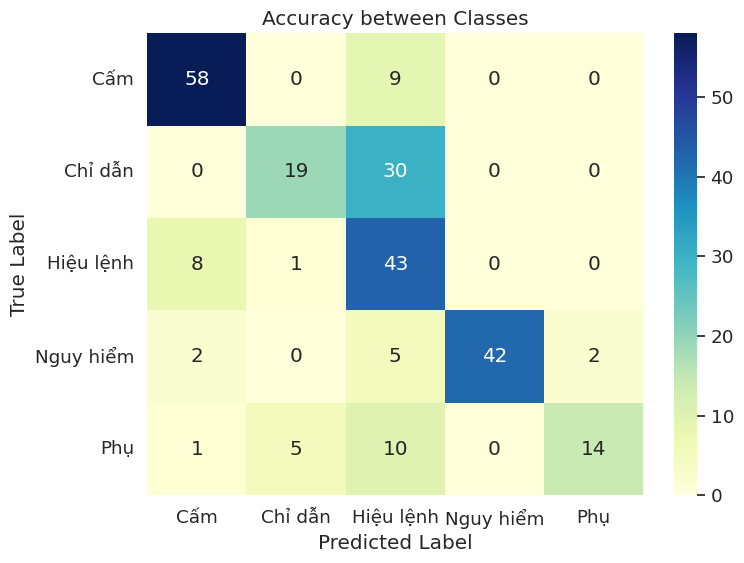

In [ ]:
plt.figure(figsize=(8,6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix , annot=True, fmt="d", cmap = "YlGnBu",
            xticklabels=["Cấm", "Chỉ dẫn", "Hiệu lệnh", "Nguy hiểm", "Phụ"],
            yticklabels=["Cấm", "Chỉ dẫn", "Hiệu lệnh", "Nguy hiểm", "Phụ"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Accuracy between Classes')
plt.show()

#SVM

In [ ]:
#SVM
svm = SVC()
svm.fit(X_train_features, y_train)

SVC()

In [ ]:
test_prediction_svm = svm.predict((X_test_features))
test_accuracy_svm = accuracy_score(y_test, test_prediction_svm)
print("Test accuracy with svm:", test_accuracy_svm)

Test accuracy with svm: 0.7670682730923695


In [ ]:
print("SVM with optimal parameters Classification report:")
print(classification_report(y_test, test_prediction_svm))
print("Test accuracy:", test_accuracy_svm)

SVM with optimal parameters Classification report:
              precision    recall  f1-score   support

         Cam       0.75      0.90      0.82        67
      Chidan       0.68      0.78      0.72        49
    Hieulenh       0.74      0.50      0.60        52
    Nguyhiem       1.00      0.90      0.95        51
         Phu       0.66      0.70      0.68        30

    accuracy                           0.77       249
   macro avg       0.77      0.75      0.75       249
weighted avg       0.77      0.77      0.76       249

Test accuracy: 0.7670682730923695


# Tối ưu SVM

In [ ]:
from sklearn import svm

svm_clf = svm.SVC(kernel='rbf', gamma=0.001, C=100)
svm_clf.fit(X_train_features, y_train)

test_prediction_svm = svm_clf.predict(X_test_features)


print("Classification Report:")
print(classification_report(y_test, test_prediction_svm))
print("Accuracy:", accuracy_score(y_test, test_prediction_svm))

Classification Report:
              precision    recall  f1-score   support

         Cam       0.82      0.96      0.88        67
      Chidan       0.74      0.80      0.76        49
    Hieulenh       0.77      0.65      0.71        52
    Nguyhiem       1.00      0.90      0.95        51
         Phu       0.71      0.67      0.69        30

    accuracy                           0.82       249
   macro avg       0.81      0.79      0.80       249
weighted avg       0.82      0.82      0.81       249

Accuracy: 0.8152610441767069


In [ ]:
# Heatmap
label_encoding = {
    'Cam': 0,
    'Chidan': 1,
    'Hieulenh': 2,
    'Nguyhiem': 3,
    'Phu': 4
}

In [ ]:
y_test_encoded = [label_encoding[label] for label in y_test]
test_prediction_svm_encoded = [label_encoding[label] for label in test_prediction_svm]

In [ ]:
conf_matrix = confusion_matrix(y_test_encoded, test_prediction_svm_encoded)

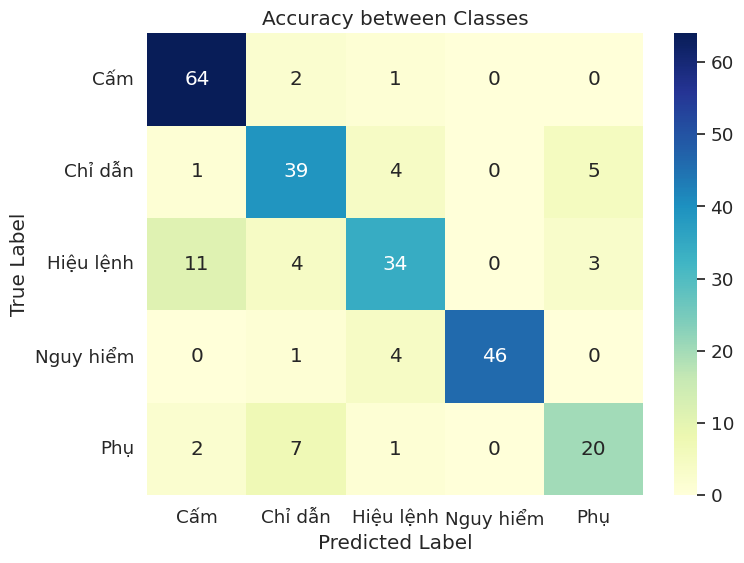

In [ ]:
plt.figure(figsize=(8,6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix , annot=True, fmt="d", cmap="YlGnBu",
            xticklabels=["Cấm", "Chỉ dẫn", "Hiệu lệnh", "Nguy hiểm", "Phụ"],
            yticklabels=["Cấm", "Chỉ dẫn", "Hiệu lệnh", "Nguy hiểm", "Phụ"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Accuracy between Classes')
plt.show()

# Decision tree

In [ ]:
decision_tree_model = DecisionTreeClassifier()
decision_tree_model.fit(X_train_features, y_train)

DecisionTreeClassifier()

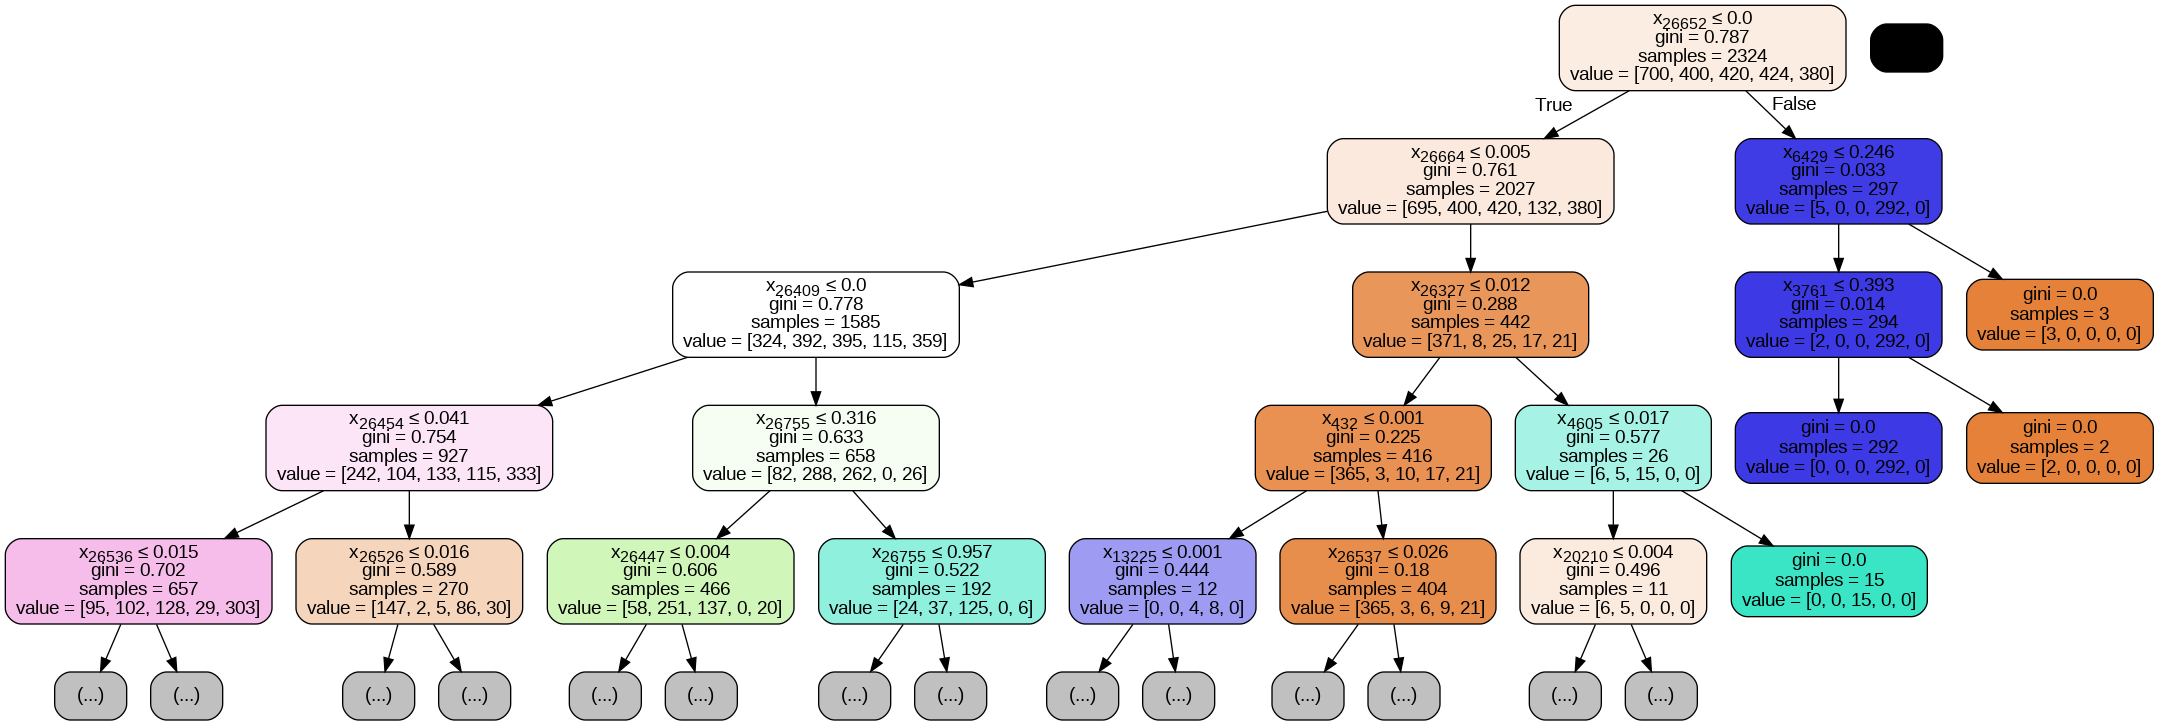

In [ ]:
dot_data = StringIO()
export_graphviz(decision_tree_model, out_file=dot_data, filled=True, rounded=True, special_characters=True, max_depth=4)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

Image(graph.create_png())

In [ ]:
test_prediction_decision_tree = decision_tree_model.predict((X_test_features))
test_accuracy_decision_tree = accuracy_score(y_test, test_prediction_decision_tree)
print("Test accuracy with decision tree:", test_accuracy_decision_tree)

Test accuracy with decision tree: 0.7188755020080321


In [ ]:
print(classification_report(y_test, test_prediction_decision_tree))

              precision    recall  f1-score   support

         Cam       0.76      0.79      0.77        67
      Chidan       0.58      0.63      0.61        49
    Hieulenh       0.62      0.58      0.60        52
    Nguyhiem       0.92      0.88      0.90        51
         Phu       0.69      0.67      0.68        30

    accuracy                           0.72       249
   macro avg       0.72      0.71      0.71       249
weighted avg       0.72      0.72      0.72       249



# Tối ưu Decision Tree

In [ ]:
decision_tree_model = DecisionTreeClassifier(max_depth = 10, criterion = 'entropy', min_samples_split = 2, min_samples_leaf = 4)
decision_tree_model.fit(X_train_features, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=4)

In [ ]:
test_prediction_decision_tree = decision_tree_model.predict((X_test_features))
test_accuracy_decision_tree = accuracy_score(y_test, test_prediction_decision_tree)
print("Test accuracy with decision tree:", test_accuracy_decision_tree)

Test accuracy with decision tree: 0.7710843373493976


In [ ]:
print("Decision tree with optimal parameters Classification report:")
print(classification_report(y_test, test_prediction_decision_tree))

Decision tree with optimal parameters Classification report:
              precision    recall  f1-score   support

         Cam       0.81      0.93      0.86        67
      Chidan       0.60      0.80      0.68        49
    Hieulenh       0.79      0.50      0.61        52
    Nguyhiem       0.94      0.86      0.90        51
         Phu       0.78      0.70      0.74        30

    accuracy                           0.77       249
   macro avg       0.78      0.76      0.76       249
weighted avg       0.78      0.77      0.77       249



#Conf_matrix

In [ ]:
label_encoding = {
    'Cam': 0,
    'Chidan': 1,
    'Hieulenh': 2,
    'Nguyhiem': 3,
    'Phu': 4
}

y_test_encoded = [label_encoding[label] for label in y_test]
test_prediction_decisiontree_encoded = [label_encoding[label] for label in test_prediction_decision_tree]

In [ ]:
conf_matrix = confusion_matrix(y_test_encoded, test_prediction_decisiontree_encoded)

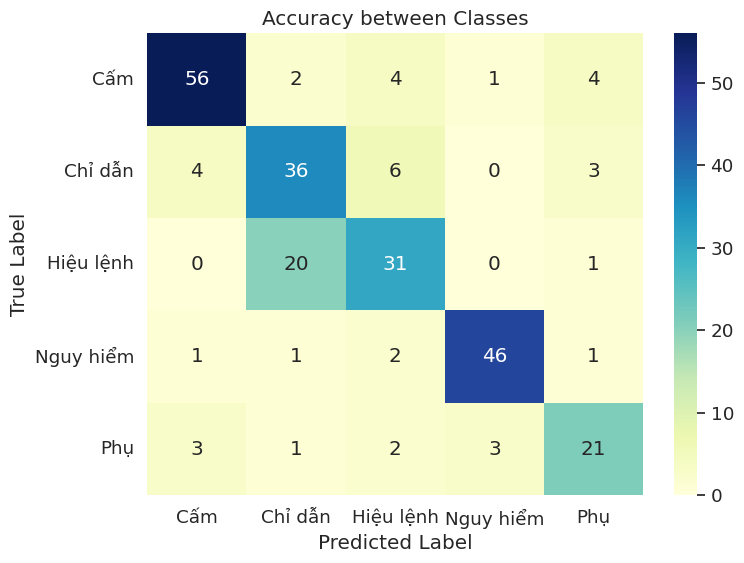

In [ ]:
plt.figure(figsize=(8,6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix , annot=True, fmt="d", cmap="YlGnBu",
            xticklabels=["Cấm", "Chỉ dẫn", "Hiệu lệnh", "Nguy hiểm", "Phụ"],
            yticklabels=["Cấm", "Chỉ dẫn", "Hiệu lệnh", "Nguy hiểm", "Phụ"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Accuracy between Classes')
plt.show()

# Save and Load models

In [ ]:
path_models = '/gdrive/MyDrive/CS231_MODEL/Save_models/'
dump(knn, path_models + 'knn.joblib')
dump(svm_clf, path_models + 'svm.joblib')
dump(decision_tree_model, path_models + 'decision_tree.joblib')

['/gdrive/MyDrive/CS231_MODEL/Save_models/decision_tree.joblib']

In [ ]:
# Chạy cái này nè :>
path_models = '/gdrive/MyDrive/CS231_MODEL/Save_models/'
knn = load(path_models + 'knn.joblib')
svm = load(path_models + 'svm.joblib')
decision_tree = load(path_models + 'decision_tree.joblib')

In [ ]:
y_pred_knn = knn.predict(X_test_features)
y_pred_svm = svm.predict(X_test_features)
y_pred_tree = decision_tree.predict(X_test_features)

In [ ]:
accuracy_knn = accuracy_score(y_test, y_pred_knn)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
accuracy_tree = accuracy_score(y_test, y_pred_tree)

In [ ]:
accuracy_knn, accuracy_svm, accuracy_tree

(0.7068273092369478, 0.8152610441767069, 0.7710843373493976)

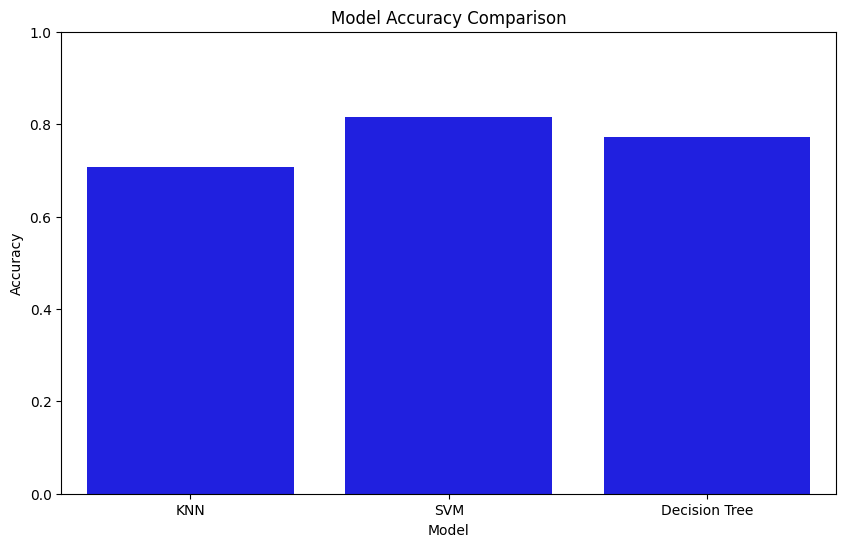

In [ ]:
models = ['KNN', 'SVM', 'Decision Tree']
accuracies = [accuracy_knn, accuracy_svm, accuracy_tree]

plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=accuracies, color='blue')
plt.ylim(0, 1)
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

# Test new Image

In [ ]:
image_path = '/gdrive/MyDrive/CS231_MODEL/testpictures/test'
os.listdir(image_path)

['Picture1.png',
 'Picture2.png',
 'Picture3.png',
 'Picture4.png',
 'Picture5.png',
 'Picture6.png',
 'Picture7.png',
 'Picture8.png',
 'Picture9.png',
 'Picture10.png',
 'Picture11.png',
 'Picture12.png',
 'Picture13.png',
 'Picture14.png',
 'Picture15.png',
 'Picture16.png',
 'Picture17.png',
 'Picture18.png',
 'Picture19.png',
 'Picture20.png',
 'Picture21.png',
 'Picture22.png',
 'Picture23.png',
 'Picture24.png',
 'Picture25.png',
 'Picture26.png']

In [ ]:
image = os.path.join(image_path, 'Picture24.png')
image = cv.imread(image)
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
image = cv.resize(image, (224, 224))
image_features = np.array([combined_features(image)])

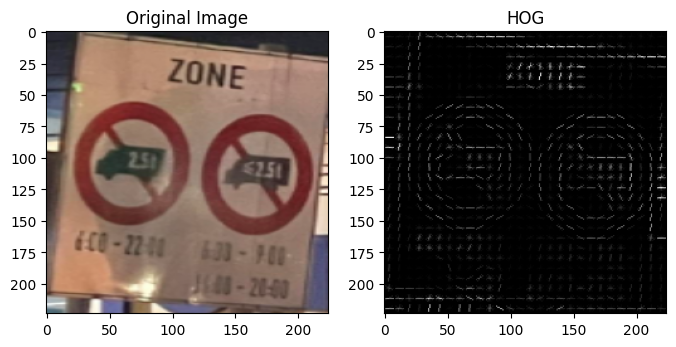

In [ ]:
plt.figure(figsize = (8, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(extract_hog_features(image)[1], cmap = 'gray')
plt.title('HOG')
plt.show()

In [ ]:
colors = ('r', 'g', 'b')

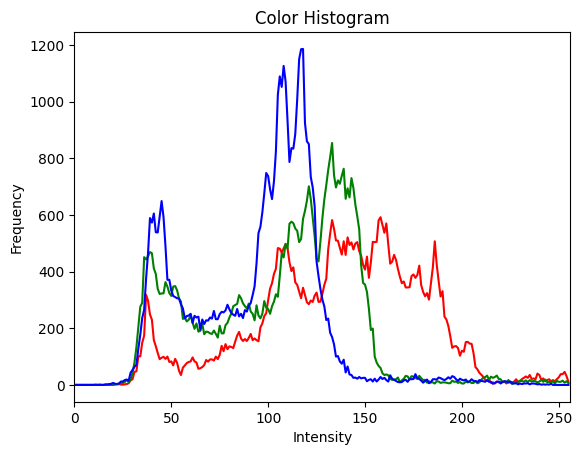

In [ ]:
for i, color in enumerate(colors):
    histogram = cv.calcHist([image], [i], None, [256], [0, 256])
    plt.plot(histogram, color=color)
    plt.xlim([0, 256])

plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.title('Color Histogram')
plt.show()

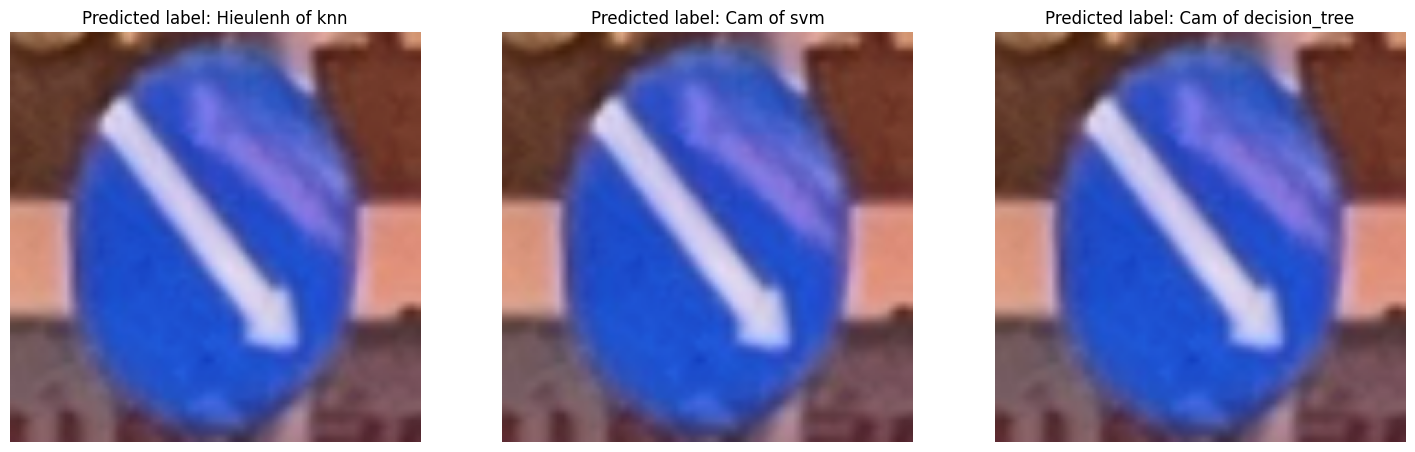

In [ ]:
# Đánh giá
model = [knn, svm, decision_tree]
models = ['knn', 'svm', 'decision_tree']
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i in range(3):
  predictions = model[i].predict(image_features)
  axes[i].imshow(image)
  axes[i].set_title(f"Predicted label: {predictions[0]} of {models[i]}")
  axes[i].axis('off')
 dự đoán sai
plt.show()

# Đánh giá ảnh thực tế: mờ, bị che, tối, biển gây nhầm


In [ ]:
data_path = '/gdrive/MyDrive/CS231_MODEL/testpictures'

In [ ]:
os.listdir(data_path)

['confusion', 'blur', 'dark', 'covered', 'test']

In [ ]:
# Confusion
def LoadImages(data_image):
  data = []
  for image in os.listdir(data_image):
    image_path = os.path.join(data_image, image)
    image = cv.imread(image_path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image = cv.resize(image, (224, 224))
    data.append(image)
  return data

In [ ]:
list_image = LoadImages(os.path.join(data_path, 'blur'))
list_image_features = np.array([combined_features(img) for img in list_image])

In [ ]:
models = [knn, svm, decision_tree]
model = ["KNN", 'SVM', 'Decision_tree']

KNN
SVM
Decision_tree


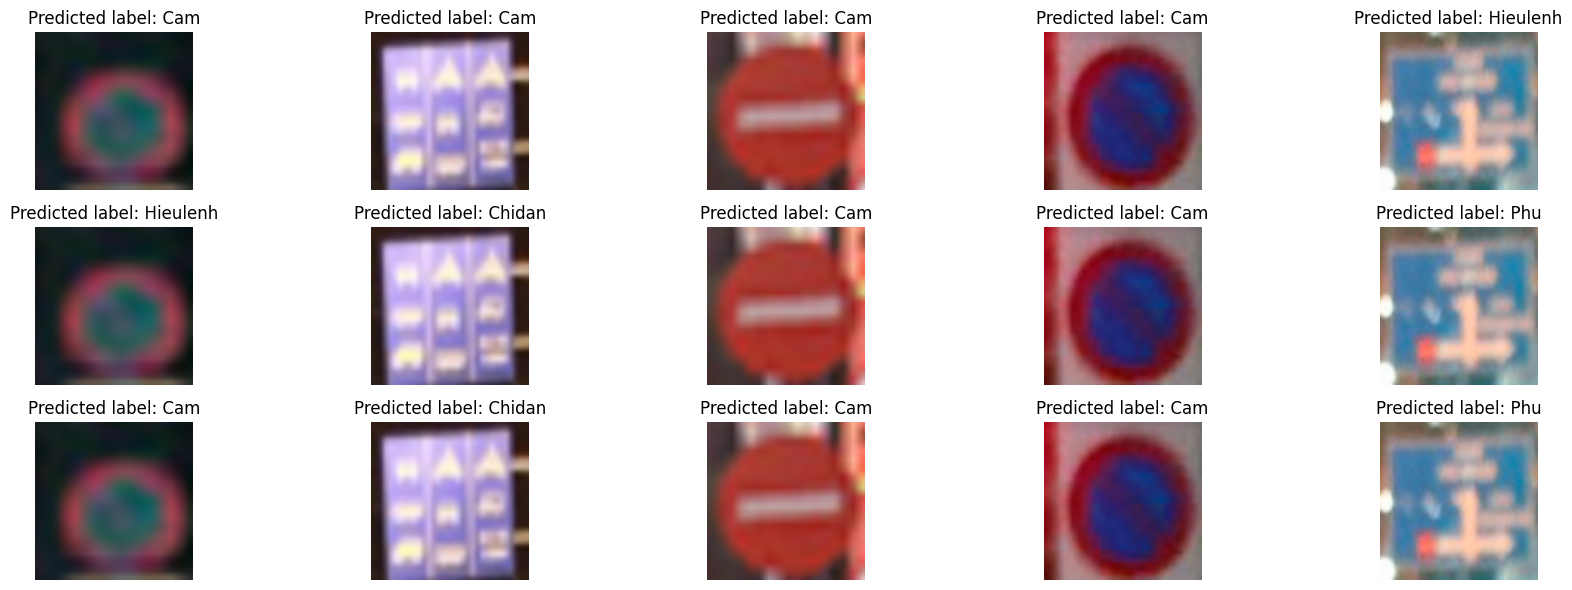

In [ ]:
fig, axes = plt.subplots(3, 5, figsize=(18, 6))
for i in range(3):
    print(model[i])
    predictions = models[i].predict(list_image_features)
    for j in range(len(list_image)):
      axes[i][j].imshow(list_image[j])
      axes[i][j].set_title(f"Predicted label: {predictions[j]}")
      axes[i][j].axis('off')
plt.tight_layout()
plt.show()

# Kiem tra

In [ ]:
image_dark = '/gdrive/MyDrive/CS231_MODEL/testpictures/dark/dark1.jpg'

In [ ]:
image_dark = cv.imread(image_dark)

In [ ]:
image_dark = cv.cvtColor(image_dark, cv.COLOR_BGR2RGB)

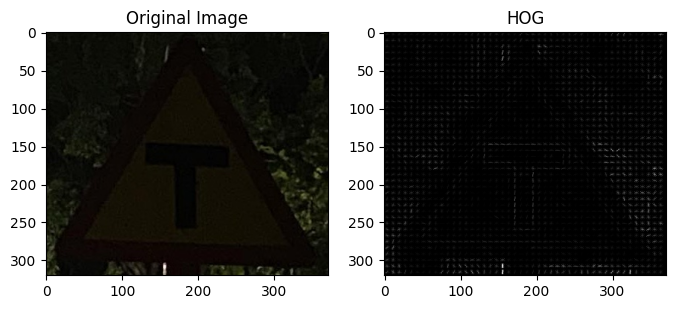

In [ ]:
plt.figure(figsize = (8, 6))
plt.subplot(1, 2, 1)
plt.imshow(image_dark)
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(extract_hog_features(image_dark)[1], cmap = 'gray')
plt.title('HOG')
plt.show()

<Figure size 800x600 with 0 Axes>

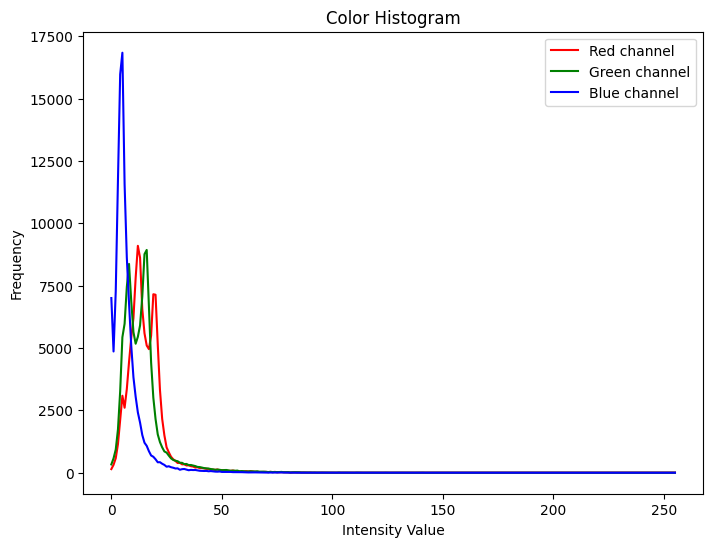

In [ ]:
def extract_color_histogram_RGB(image):
    hist_red = cv.calcHist([image], [0], None, [256], [0, 256])
    hist_green = cv.calcHist([image], [1], None, [256], [0, 256])
    hist_blue = cv.calcHist([image], [2], None, [256], [0, 256])
    return hist_red, hist_green, hist_blue

def plot_color_histogram_2d(hist_red, hist_green, hist_blue):
    plt.figure(figsize=(8, 6))
    plt.plot(hist_red, color='r', label='Red channel')
    plt.plot(hist_green, color='g', label='Green channel')
    plt.plot(hist_blue, color='b', label='Blue channel')
    plt.title('Color Histogram')
    plt.xlabel('Intensity Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

plt.figure(figsize=(8, 6))


hist_red, hist_green, hist_blue = extract_color_histogram_RGB(image_dark)
plot_color_histogram_2d(hist_red, hist_green, hist_blue)

plt.show()


In [ ]:
image_dark = '/gdrive/MyDrive/CS231_MODEL/testpictures/blur/blur1.jpg'

In [ ]:
image_dark = '/gdrive/MyDrive/CS231_MODEL/testpictures/covered/cover1.jpg'

# Tập test

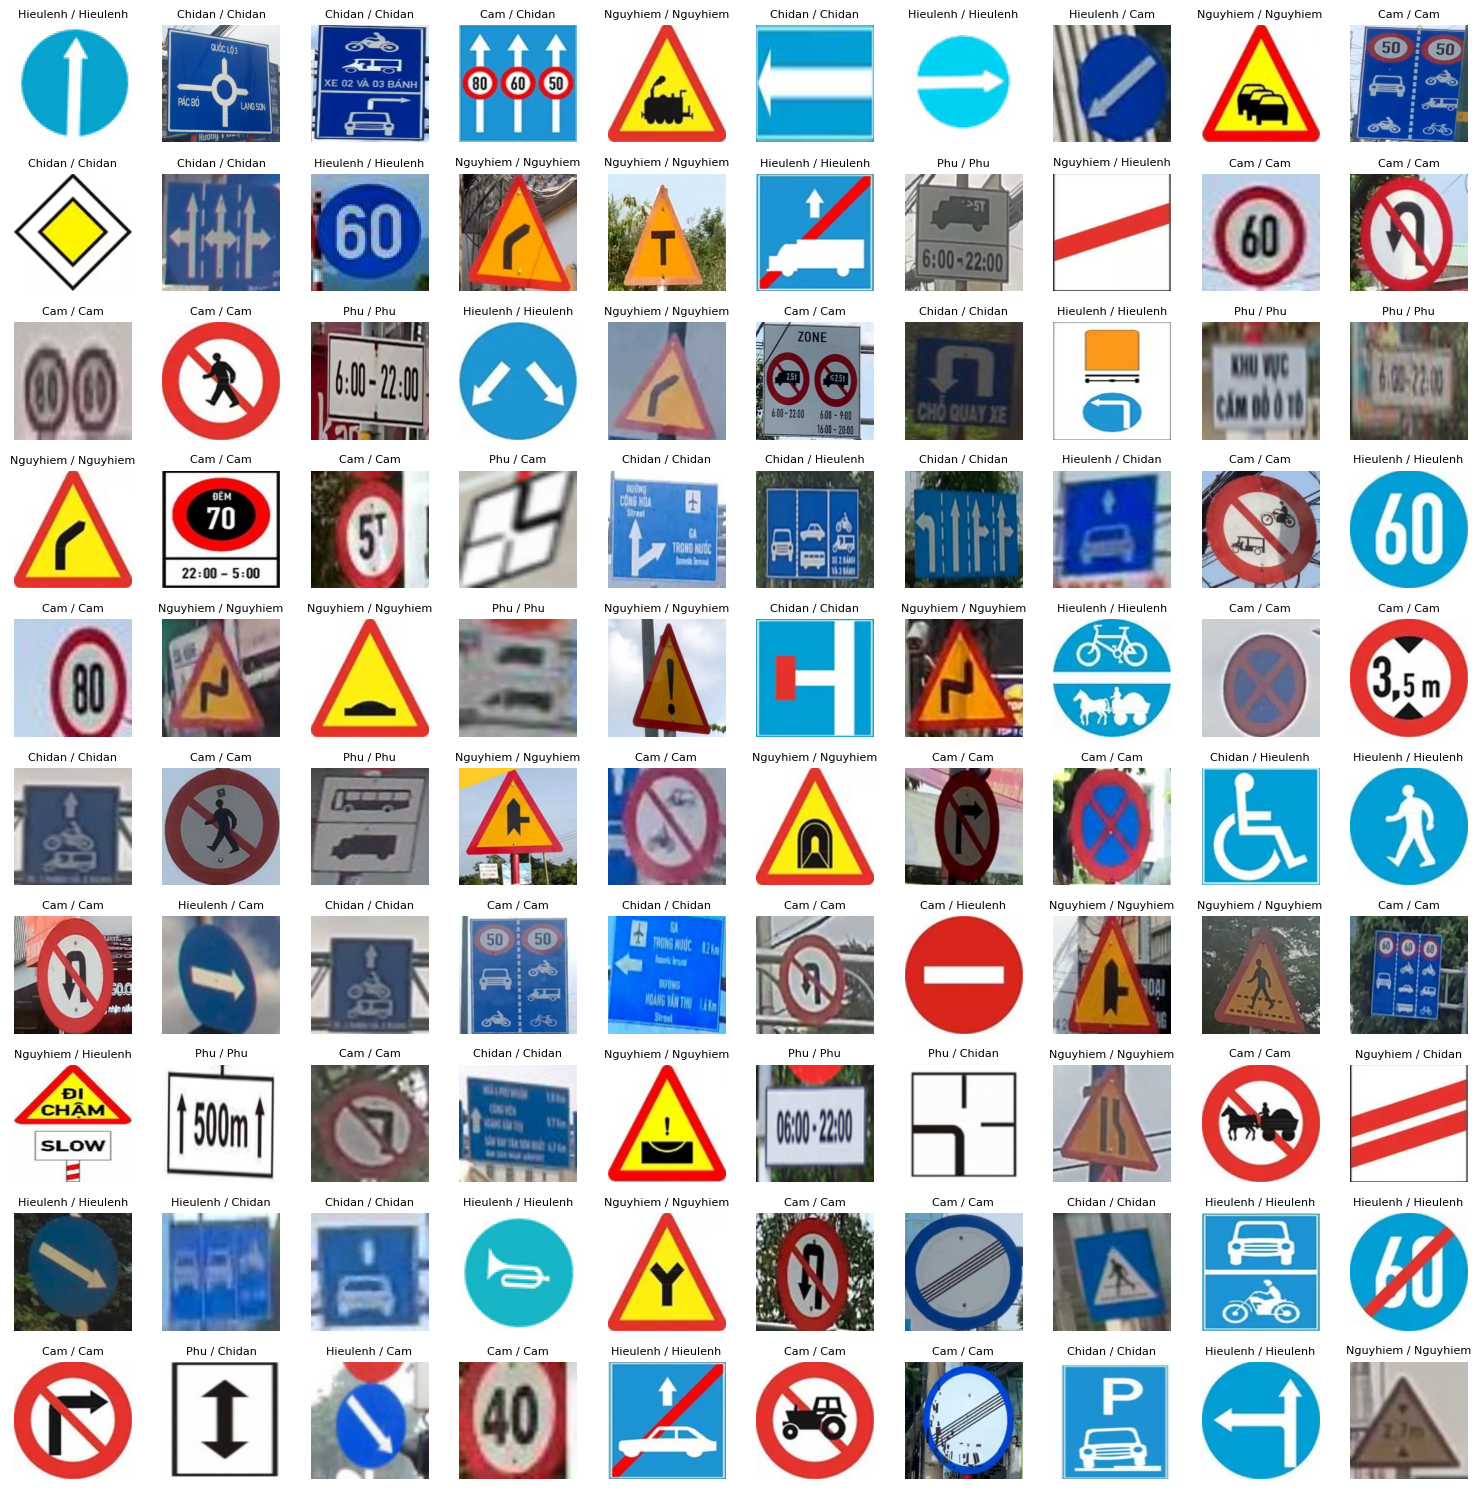

In [ ]:
fig, axes = plt.subplots(10, 10, figsize=(15, 15))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[i])
    ax.set_title(f"{y_test[i]} / {test_prediction_svm[i]}", fontsize=8)
    ax.axis('off')
plt.tight_layout()
plt.show()